# Import modules

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Data Pre-Processing
First, let's load the dataset and add a binary affair column.

In [17]:
# load dataset
df = sm.datasets.fair.load_pandas().data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [18]:
# add "affair" column: 1 represents having affairs, 0 represents not
df['affair'] = (df.affairs > 0).astype(int)
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [21]:
# Records identified where there's no affair 
df.loc[df.affairs<=0].head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
2053,4.0,32.0,9.0,2.0,3.0,14.0,2.0,4.0,0.0,0
2054,4.0,27.0,6.0,0.0,2.0,14.0,3.0,4.0,0.0,0
2055,4.0,22.0,2.5,0.0,2.0,14.0,3.0,2.0,0.0,0
2056,5.0,42.0,23.0,4.0,3.0,16.0,3.0,5.0,0.0,0
2057,5.0,27.0,2.5,1.0,3.0,20.0,2.0,2.0,0.0,0


# Data Exploration

In [22]:
# Average of all features group by affair
df.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the rate_marriage variable.

In [23]:
df.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

# Data Visualization

In [25]:
# show plots in the notebook
%matplotlib inline

Text(0,0.5,'Frequency')

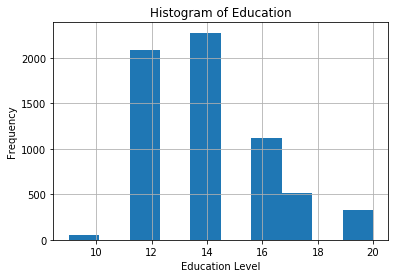

In [28]:
# histogram of education
df.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

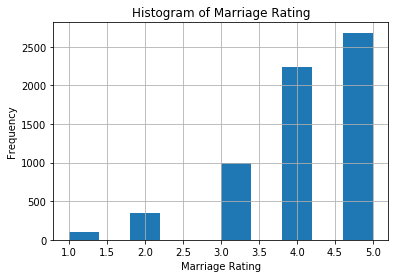

In [29]:
# histogram of marriage rating
df.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

Text(0,0.5,'Frequency')

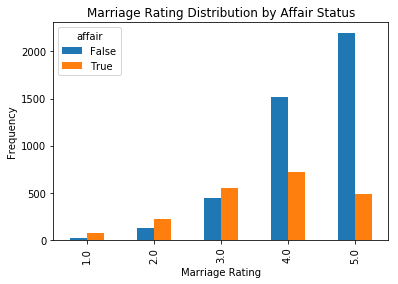

In [30]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(df.rate_marriage, df.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0,0.5,'Percentage')

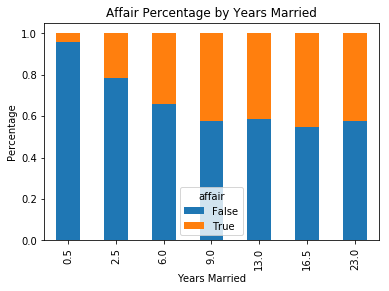

In [31]:
affair_yrs_married = pd.crosstab(df.yrs_married, df.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

# Prepare Data for Logistic Regression
To prepare the data, I want to add an intercept column as well as dummy variables for occupation and occupation_husb, since I'm treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

In [35]:
# create dataframes with an intercept column and dummy variables for occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  df, return_type="dataframe")
X.columns

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

The column names for the dummy variables are ugly, so let's rename those.

In [40]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [43]:
# flatten y into a 1-D array
y = np.ravel(y)

In [44]:
X.columns

Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
       'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
       'age', 'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')

# Logistic Regression
Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [45]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.72588752748978946

In [49]:
# what percentage had affairs?
y.mean()

0.32249450204209867

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [50]:
# examine the coefficients
X.columns, np.transpose(model.coef_)

(Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
        'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
        'age', 'yrs_married', 'children', 'religious', 'educ'],
       dtype='object'), array([[ 1.48983589],
        [ 0.18806639],
        [ 0.49894787],
        [ 0.25066856],
        [ 0.83900806],
        [ 0.83390843],
        [ 0.19063594],
        [ 0.29783271],
        [ 0.16140885],
        [ 0.18777091],
        [ 0.19401637],
        [-0.70312336],
        [-0.05841777],
        [ 0.10567654],
        [ 0.01691927],
        [-0.37113627],
        [ 0.0040165 ]]))

Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. For both, wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

# Model Evaluation Using a Validation Set

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [51]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [52]:
# predict class labels for the test set
predicted = model2.predict(X_test)
predicted

array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

In [53]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[ 0.3514634 ,  0.6485366 ],
       [ 0.90955084,  0.09044916],
       [ 0.72567333,  0.27432667],
       ..., 
       [ 0.55727385,  0.44272615],
       [ 0.81207043,  0.18792957],
       [ 0.74734601,  0.25265399]])

As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

Now let's generate some evaluation metrics.

In [54]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.729842931937
0.745950606951


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics.

In [55]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



# Model Evaluation Using Cross-Validation
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [56]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
scores, scores.mean()

(array([ 0.72100313,  0.70219436,  0.73824451,  0.70597484,  0.70597484,
         0.72955975,  0.7327044 ,  0.70440252,  0.75157233,  0.75      ]),
 0.7241630685514876)

Looks good. It's still performing at 73% accuracy.

# Predicting the Probability of an Affair
Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated from college, has been married for 3 years. She has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [57]:
model.predict_proba(np.array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4, 16]]))

array([[ 0.77472221,  0.22527779]])

The predicted probability of an affair is 23%.